Here we experiment with using an autoencoder to convert the output of the first NN to a simpler, narrowed set of GLs.

In [1]:
#-- Import Modules
import os
import imp
import random
import numpy as np
import matplotlib.pyplot as plt 
from google.colab import drive
import keras
from keras import backend as K
import keras.layers as kl
import keras.models as km
from keras.preprocessing import image
from tensorflow.python.client import device_lib
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model

Using TensorFlow backend.


In [20]:
#-- Set up configurations / parameters
retrain = True # retrain previously existing model
n_batch = 15
n_epochs = 30
n_test = 500
ratio = 727 # penalization ratio for GL and non-GL points based on smaller dataaset

In [3]:
#-- Mount Google Drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
#-- Directory setup
colabdir = '/content/gdrive/My Drive/Colab Notebooks/'
output_dir = '/content/gdrive/My Drive/GL_Learning/'
ddir = '/content/gdrive/Shared drives/GROUNDING_LINE_TEAM_DRIVE/ML_Yara/geocoded_v1/'
train_dir = os.path.join(ddir,'train_n%i.dir'%n_test)
test_dir = os.path.join(ddir,'test_n%i.dir'%n_test)

In [6]:
#-- Get list of images
fileList = os.listdir(train_dir)
train_list = [f for f in fileList if (f.endswith('.npy') and f.startswith('pred'))]
fileList = os.listdir(test_dir)
test_list = [f for f in fileList if (f.endswith('.npy') and f.startswith('pred'))]

In [7]:
#-- set ID_list to be passed onto data generator class
ID_list = [os.path.join(train_dir,f) for f in train_list]
N = len(ID_list)
print(N)

#-- read 1 file to get dimensions
im = np.load(ID_list[0])
h,wi,ch = im.shape
print(h,wi,ch)

#-- randomly set aside 10% of data for validation
valid_ii = random.sample(range(N),int(0.1*N))
train_ii = np.setdiff1d(np.arange(N),valid_ii)

5320
512 512 1


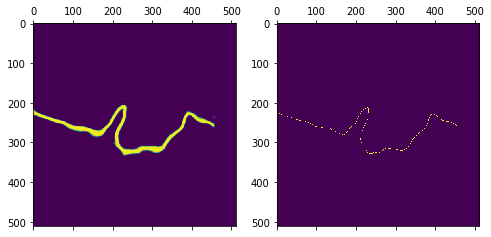

In [9]:
#-- check training and label data
lbl = np.load(ID_list[0].replace('pred','delineation'))
fig,ax = plt.subplots(1, 2,figsize=(8,4))
ax[0].matshow(im.reshape(h,wi))
ax[1].matshow(lbl.reshape(h,wi))
plt.show()

In [21]:
#-- setup generator
data_generation = imp.load_source('data_generation',os.path.join(colabdir,'data_generation.py'))
from data_generation import DataGenerator
training_generator = DataGenerator(list(np.array(ID_list)[train_ii]),batch_size=n_batch, dim=(h,wi), 
	n_channels=ch, shuffle=True)
validation_generator = DataGenerator(list(np.array(ID_list)[valid_ii]),batch_size=n_batch, dim=(h,wi), 
	n_channels=ch, shuffle=True)

In [27]:
#--------------------------
#-- Make autoencoder model
#--------------------------
#-- define input
inputs = kl.Input((h,wi,ch))

#-- encoder
c = kl.Conv2D(16,3,activation='relu',padding='same')(inputs)
p = kl.MaxPooling2D(pool_size=(2,2))(c)

c = kl.Conv2D(32,3,activation='relu',padding='same')(p)
p = kl.MaxPooling2D(pool_size=(2,2))(c)

# c = kl.Conv2D(32,3,activation='relu',padding='same')(p)
# p = kl.MaxPooling2D(pool_size=(2,2))(c)

#-- decoder
c = kl.Conv2D(32, 3, activation='relu', padding='same')(p)
u = kl.UpSampling2D((2, 2))(c)

# c = kl.Conv2D(32, 3, activation='relu', padding='same')(u)
# u = kl.UpSampling2D((2, 2))(c)

c = kl.Conv2D(16, 3, activation='relu',padding='same')(u)
u = kl.UpSampling2D((2, 2))(c)

decoded = kl.Conv2D(1, 3, activation='sigmoid', padding='same')(u)

flattened = kl.Reshape((h*wi,1,))(decoded)

model = km.Model(inputs=inputs,outputs=flattened)

In [14]:
#-- define custom loss function
def customLoss(yTrue,yPred):
  return -1*K.mean(ratio*(yTrue*K.log(yPred+1e-32)) + ((1. - yTrue)*K.log(1-yPred+1e-32)))

In [28]:
#-- compile imported model
model.compile(loss=customLoss,optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 512, 512, 16)      160       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 256, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 256, 256, 32)      0   

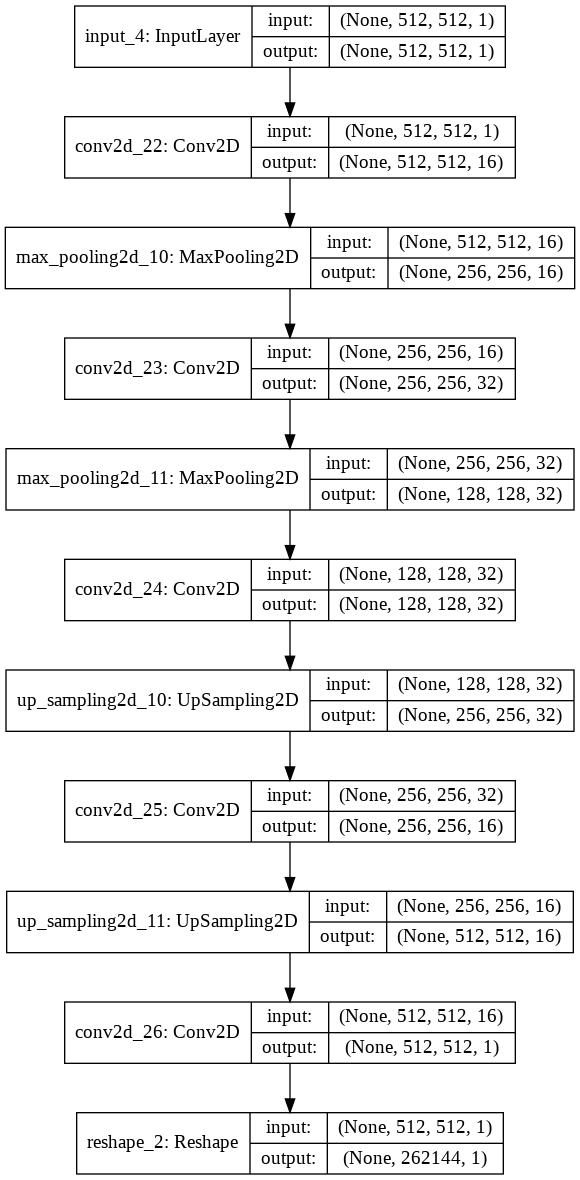

In [29]:
#-- plot and save model diagaram
plot_model(model,to_file=os.path.join(output_dir,'autoencoder_diagram.png'),show_shapes=True)

In [30]:
#-- checkpoint file
chk_file = os.path.join(output_dir,'autoencoder_weights.h5')

#-- if file exists, read model from file
if os.path.isfile(chk_file):
  print('Check point exists; loading model from file.')
  #-- load weights
  model.load_weights(chk_file)
else:
  print('Model does not previously exist.')

Model does not previously exist.


In [35]:
#-- Train the model
if (retrain) or (not os.path.isfile(chk_file)):
  print('Training model...')
  #-- create checkpoint
  model_checkpoint = keras.callbacks.ModelCheckpoint(chk_file, monitor='loss',
                                                     verbose=1, 
                                                     save_best_only=False)
  lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5,
                                  verbose=1, mode='auto', min_delta=0.0001, 
                                  cooldown=0, min_lr=0)
  es_callback = EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=5,
     verbose=1, mode='auto')
  #-- now fit the model
  history = model.fit_generator(generator=training_generator,
                                validation_data=validation_generator,
                                use_multiprocessing=True,
                                workers=10, epochs=n_epochs,
                                shuffle=True, verbose=1,
                                callbacks=[lr_callback,es_callback,model_checkpoint])

Training model...
Epoch 1/30
319/319 [==============================] - 205s 643ms/step - loss: 0.0682 - accuracy: 0.9854 - val_loss: 0.0616 - val_accuracy: 0.9855

Epoch 00001: saving model to /content/gdrive/My Drive/GL_Learning/autoencoder_weights.h5
Epoch 2/30
319/319 [==============================] - 202s 634ms/step - loss: 0.0680 - accuracy: 0.9854 - val_loss: 0.0593 - val_accuracy: 0.9861

Epoch 00002: saving model to /content/gdrive/My Drive/GL_Learning/autoencoder_weights.h5


OSError: ignored

In [36]:
#-- save model if it fails
model.save(chk_file.replace('.h5','_final.h5'),overwrite=True)

In [ ]:
#-- save history to file
outfile = open(os.path.join(output_dir,
                      'autoencoder_history.txt'),'w')
outfile.write('Epoch loss\tval_loss\tacc\tval_acc\n')
for i in range(len(history.history['loss'])):
    outfile.write('%i\t%f\t%f\t%f\t%f\n'%(i,history.history['loss'][i],history.history['val_loss'][i],\
        history.history['accuracy'][i],history.history['val_accuracy'][i]))
outfile.close()

#-- Make plots for training history
for item,name in zip(['accuracy','loss'],['Accuracy','Loss']):
  fig = plt.figure(1,figsize=(8,6))
  plt.plot(history.history[item])
  plt.plot(history.history['val_%s'%item])
  plt.title('Model %s'%name)
  plt.ylabel(name)
  plt.xlabel('Epochs')
  plt.legend(['Training', 'Validation'], loc='upper left')
  plt.savefig(os.path.join(output_dir,
                      'autoencoder_history.pdf')
                      ,format='pdf')
  plt.close(fig)

In [ ]:
print('Model is trained. Running on Train data...')
#-------------------------------
#-- First run on training data
#-------------------------------
#-- make output directory
out_dir = os.path.join(output_dir,'Train_predictions.dir',
                       'autoencoder.dir')
if (not os.path.isdir(out_dir)):
  os.mkdir(out_dir)
# Read the images 500 at a time to save memory
idx = 0 #-- index count
incr = 500 #- reading increment
while idx < len(train_list):
  in_imgs = np.empty((incr,h,wi,ch))
  for i,f in enumerate(train_list[idx:idx+incr]):
    in_imgs[i,] = np.load(os.path.join(train_dir,f)) 
  out_imgs = model.predict(in_imgs, batch_size=1, verbose=1)
  out_imgs = out_imgs.reshape(out_imgs.shape[0],h,wi,out_imgs.shape[2])

  #-- save output images
  for i,f in enumerate(train_list[idx:idx+incr]):
    im = image.array_to_img(out_imgs[i]) 
    im.save(os.path.join(out_dir,f.replace('pred','autoenc').replace('npy','png')))
    #-- also save array to file
    np.save(os.path.join(out_dir,f.replace('pred','autoenc')),out_imgs[i])
  #-- increment index count
  idx += incr

In [40]:
#-- Read test data all at once
test_imgs = np.ones((n_test,h,wi,ch))
for i,f in enumerate(test_list):
    test_imgs[i,] = np.load(os.path.join(test_dir,f))

In [41]:
#-------------------------------
#-- Run on test data
#-------------------------------
out_imgs = model.predict(test_imgs, batch_size=1, verbose=1)
out_imgs = out_imgs.reshape(out_imgs.shape[0],h,wi,out_imgs.shape[2])
print(out_imgs.shape)

#-- make output directory
out_dir = os.path.join(output_dir,'Test_predictions.dir',
                       'autoencoder.dir')
if (not os.path.isdir(out_dir)):
  os.mkdir(out_dir)

#-- save output images
for i,f in enumerate(test_list):
  im = image.array_to_img(out_imgs[i]) 
  im.save(os.path.join(out_dir,f.replace('pred','autoenc').replace('npy','png')))
  #-- also save array to file
  np.save(os.path.join(out_dir,f.replace('pred','autoenc')),out_imgs[i])

500/500 [==============================] - 3s 6ms/step
(500, 512, 512, 1)
